# FINM 36700 
# HOMEWORK #5

## 1. The Case
1. The factors used by Fama & French includes (other than MKT):
    - size factor (i.e. size of a firm or the market cap of a firm). They observed that, all else being equal, firms with smaller market caps have higher average returns over time relative to firms with larger market caps. Several pieces of papers have been pointed to various reasonings for this effect, but the clearest seems to be done by various papers by AQR, which posits that most of the effects are noise (i.e. volatility of junky small firms), and that by controlling for these factors, can we see a robust size premia exists only for quality firms. See Size Matters, If You Can Control Your Junk by AQR's team. This can be measured by grouping stocks into their percentiles by market cap.
    - value factor (i.e. specifically book value to market cap). This effect is potentially due to either: a compensation for risk taken for a potentially less profitable and/or more distressed company, or investors mis-pricing assets due to a wrong read of information. The truth probably lies somewhere in the middle of this. There are multiple ways to measure the value approach (I would argue that the measure that provides the highest sustained premia comes from EV/EBIT), but the Fama-French approach was using B/M and separating these into quintles.
    - profitability factor (i.e. ratio of firm's operating profit to book value). Fama and Frehcnh used these and sorted companies from high to low profitability, with the argument being that higher profitability yield higher quality companies yield higher returns. Interestingly, this effect might not be as robust as expected, as removing profitability might yield higher annual returns (see Deep Value by Tobias Carlisle). 
    - investment factor (i.e. percentage change in the value of the firm's assets over the year). The theory is that the firm's increased investment signals lack of future earnings. 

    The one factor not included by Fama and French but is significant is the momentum factor. The effects are highly debatable. Fama and French have tested and controlled for this factor, but similarly, others have shown outperformance using the momentum signal. In the case, it is measured by sorting stocks based on their appreciation in the previous year. 

2. The factor portfolio could be long only or can can be approached via a long-short manner (short lowest quintle long highest quintile). Traditionally, the companies are weighted by market cap. 

3. Not heavily discussed in case. 

4. No 1-6 in case. Figure 6 references momemtum quintiles

5. Traditional factor ETFs have weights based on the market cap of the companies, but "smart beta" attempts to improve this by including weightages based on the other factors such as B/M, profitability, or performance such as momentum. 

6. Unclear what this question is referring to but I would assume no. For anyone buying to value stock, someone must deem it to be not a "value", for them to sell it to them. Hence, it is impossible for everyone to be exposed to the value factor. 

7. Standard diversification strategies goes into various sectors and asset classes that may not produce outsized returns on average. By using factors, and diversifying across higher average return factors, you could have a "higher quality" diversification weighted across factors. 

## 2. The Factors

In [39]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
warnings.filterwarnings('ignore')

In [40]:
#helper functions
def freq_multiplier(input_freq, output_freq):
    multiplier = 1

    if input_freq == 'monthly':
        multiplier *= 12
    elif input_freq == 'weekly':
        multiplier *= 52
    elif input_freq == 'daily':
        multiplier *= 252
    else:
        print('invalid input frequency')
        return
    
    if output_freq == 'monthly':
        multiplier /= 12
    elif output_freq == 'weekly':
        multiplier /= 52
    elif output_freq == 'daily':
        multiplier /= 252
    elif output_freq == 'annually':
        pass

    return multiplier

def calc_stats(df, input_freq = 'monthly', output_freq = 'annually'):
    """
    Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    multiplier = freq_multiplier(input_freq, output_freq)

    # calculate mean, vol, sharpe, VaR(5%), CVaR(5%) for each item in df
    summary_stats = df.mean().to_frame('Mean').apply(lambda x: x * multiplier)
    summary_stats['Volatility'] = df.std() * np.sqrt(multiplier)
    summary_stats['Sharpe Ratio'] = summary_stats['Mean'] / summary_stats['Volatility']
    summary_stats['Skewness'] = df.skew()
    summary_stats['Excess Kurtosis'] = df.kurtosis()
    summary_stats['VaR (5%)'] = df.quantile(0.05, axis = 0)
    summary_stats['CVaR (5%)'] = df[df <= df.quantile(0.05, axis = 0)].mean()

    cum_returns = (1 + df).cumprod()
    previous_peaks = cum_returns.cummax()
    drawdowns = (cum_returns - previous_peaks) / previous_peaks
    summary_stats['Max Drawdown'] = drawdowns.min()
    # find the last date of the min drawdown
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()

    # calculate recovery time
    recovery_date = []
    for col in cum_returns.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_cum = pd.DataFrame([cum_returns[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_cum[recovery_cum[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date   

    return summary_stats

# tangency weights function
def tangency_weights(df, input_freq = 'monthly', output_freq = 'annually'):
    """
    Returns the weights of the tangency portfolio for given set of returns and covariance matrix
    """
    multipler = freq_multiplier(input_freq, output_freq)

    # calculate the mean returns and covariance matrix
    mean_returns = df.mean() * multipler
    cov_matrix = df.cov() * multipler
    cov_inv = np.linalg.inv(cov_matrix)

    # calculate the tangency portfolio weights
    tangency_weights = cov_inv.dot(mean_returns)
    tangency_weights /= tangency_weights.sum()

    #create a dataframe with weights and asset names
    tangency_weights = pd.DataFrame(tangency_weights, index = df.columns, columns = ['Weights'])

    return tangency_weights

def linearRegression(seriesY,seriesX):
    
    mean =seriesY.mean()*12
    sharpe = mean/(seriesY.std()*(12**0.5))
    model = sm.OLS(seriesY,sm.add_constant(seriesX)).fit()
    rsq = model.rsquared
    
    beta = pd.DataFrame(index= [seriesY.name])
    
    for i,x in enumerate(seriesX):
         beta[x] = model.params[i+1]
    
    betaCols = [i+'Beta' for i in seriesX]
    beta = beta.rename(columns = dict(zip(beta.columns,betaCols)))
    
    treynor = mean/beta[beta.columns[0]]
    alpha = model.params[0]*12
    information = alpha/(model.resid.std()*np.sqrt(12))
    
    RegressionStats = pd.DataFrame({'Mean Return':mean,'Sharpe Ratio':sharpe,'R Squared':rsq,\
                         'Alpha':alpha, 'Information Ratio':information, 'Treynor':treynor},index= [seriesY.name])
    
    return pd.concat([RegressionStats,beta], axis =1)

In [41]:
FILEIN = '/Users/kaiwentay/Documents/GitHub/finm-portfolio-2023/data/factor_pricing_data.xlsx'
sheet_des = 'descriptions'
sheet_factorexrets = 'factors (excess returns)'
sheet_portfolioexrets = 'portfolios (excess returns)'
sheet_rfr = 'risk-free rate'

# reference github repo finm-portfolio-2023
des = pd.read_excel(FILEIN, sheet_name = sheet_des)
factorexrets = pd.read_excel(FILEIN, sheet_name = sheet_factorexrets).set_index('Date')
portfolioexrets = pd.read_excel(FILEIN, sheet_name = sheet_portfolioexrets).set_index('Date')
rfr = pd.read_excel(FILEIN, sheet_name = sheet_rfr).set_index('Date')

### 2.1. Analyze factors, similar to how you analyzed the three Fama-French factors in Homework 4. Also, report them for 3 subsamples: Beginning - 1980, 1981-2001, 2002-End

In [42]:
# calculate mean, vol, sharpe, VaR(5%), CVaR(5%) for each factor
factor_stats = calc_stats(factorexrets, input_freq = 'monthly', output_freq = 'annually')
factor_stats.loc[:, ['Mean', 'Volatility', 'Sharpe Ratio', 'VaR (5%)', 'CVaR (5%)']]

,Mean,Volatility,Sharpe Ratio,VaR (5%),CVaR (5%)
MKT,0.084562,0.157284,0.537641,-0.07557,-0.102822
SMB,0.011206,0.100525,0.111476,-0.04222,-0.057663
HML,0.025324,0.110162,0.229880,-0.04210,-0.066904
RMW,0.046525,0.083404,0.557824,-0.02768,-0.049689
CMA,0.032492,0.073379,0.442794,-0.02754,-0.040489
UMD,0.060925,0.155507,0.391780,-0.06819,-0.109270


In [43]:
# Report these for the following subsamples: Beginning to 1980, 1981 to 2001, 2002 to end
# calculate mean, vol, sharpe, VaR(5%), CVaR(5%) for each factor for each subsample
data_1980 = factorexrets.loc[:'1980']
data_1981_2001 = factorexrets.loc['1981':'2001']
data_2002 = factorexrets.loc['2002':]

factor_stats_1980 = calc_stats(data_1980, input_freq = 'monthly', output_freq = 'annually')
factor_stats_1981_2001 = calc_stats(data_1981_2001, input_freq = 'monthly', output_freq = 'annually')
factor_stats_2002 = calc_stats(data_2002, input_freq = 'monthly', output_freq = 'annually')

# combined summary stats for all 3 subsamples in one dataframe with period as column
factor_stats_1980['Period'] = '1980'
factor_stats_1981_2001['Period'] = '1981-2001'
factor_stats_2002['Period'] = '2002'
factor_stats_combined = pd.concat([factor_stats_1980, factor_stats_1981_2001, factor_stats_2002])
factor_stats_combined = factor_stats_combined.reset_index().rename(columns = {'index': 'Factor'})
factor_stats_combined = factor_stats_combined.set_index(['Period', 'Factor'])
factor_stats_combined = factor_stats_combined.loc[:, ['Mean', 'Volatility', 'Sharpe Ratio', 'VaR (5%)', 'CVaR (5%)']]
factor_stats_combined

Mean  Volatility  Sharpe Ratio  VaR (5%)  CVaR (5%)
Period    Factor                                                         
1980      MKT     0.202900    0.203717      0.995990 -0.082910  -0.129000
          SMB     0.053700    0.108821      0.493472 -0.049390  -0.069300
          HML    -0.198700    0.117754     -1.687412 -0.072740  -0.083300
          RMW     0.107800    0.073037      1.475957 -0.018800  -0.021000
          CMA    -0.097700    0.076936     -1.269882 -0.040650  -0.056600
          UMD     0.307800    0.234594      1.312054 -0.079715  -0.095500
1981-2001 MKT     0.077257    0.157396      0.490847 -0.064545  -0.101262
          SMB     0.001429    0.109605      0.013034 -0.043500  -0.062164
          HML     0.063776    0.111183      0.573612 -0.041790  -0.060415
          RMW     0.046914    0.091606      0.512130 -0.030160  -0.057308
          CMA     0.053157    0.077355      0.687185 -0.029990  -0.041115
          UMD     0.101686    0.145105      0.700775 -0.060980  -0.092246
2002      MKT     0.086187    0.155313      0.554923 -0.079130  -0.099992
          SMB     0.018751    0.090739      0.206642 -0.039840  -0.050292
          HML    -0.001710    0.107517     -0.015901 -0.041740  -0.072038
          RMW     0.043307    0.075282      0.575261 -0.025430  -0.043585
          CMA     0.018417    0.068581      0.268543 -0.024160  -0.037262
          UMD     0.009827    0.159709      0.061531 -0.073180  -0.126723

### 2.2 Based on the factor statistics above, answer the following:
#### 2.2.a Does each factor have a positive risk premium (positive expected excess return)?

On aggregate, yes. However, if you see the breakdown in sub-periods:
- 1980: HML and CMA provided a highly negative return. SMB was fairly ineffectual. The rest performed admirably. 
- 1981-2001: All of the factors turned positive in terms of excess returns but most of them lost ground with the exception of the HML and CMA.
- 2002-End: This picture remained largely similar, with the exception of HML and CMA losing premia. 

#### 2.2.b Does each factor have a positive risk premium (positive expected excess return)?

This isn't clearly obvious. HML had highly negative premia during the 1980s period, which could have been good in a short portfolio or as a inverse factor/indicator. It was effective during 1980-2001 time period but turned ineffective again during 2002 to present. 

### 2.3 Report the correlation matrix across the six factors.

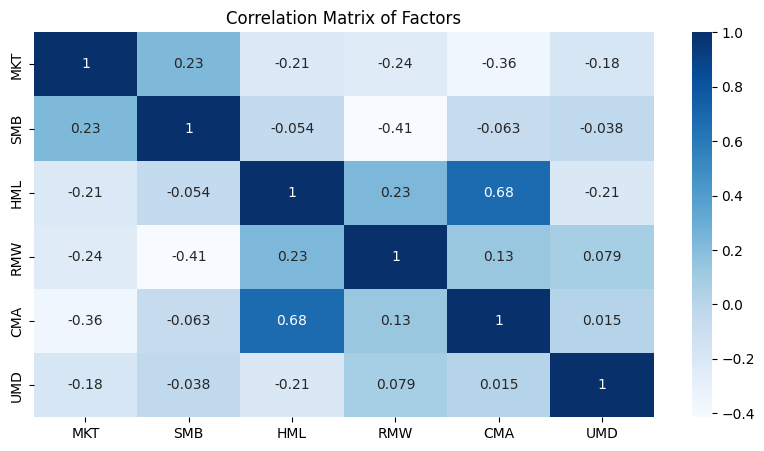

In [44]:
#correlation matrix across factors
corr_matrix = factorexrets.corr()

# plot correlation matrix
plt.figure(figsize = (10, 5))
sns.heatmap(corr_matrix, annot = True, cmap = 'Blues')
plt.title('Correlation Matrix of Factors')
plt.show()

#### 2.3.a Does the construction method succeed in keeping correlations small?
With the exception of HML - CMA, it does seem like this construction method keeps correlation fairly low. 

#### 2.3.b Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?
Once again, this is hard to parse, but on the face of it, it does look like HML can be well explained by other factors in the model, specifically PMW and CMA.

### 2.4 Report the tangency weights for a portfolio of these 6 factors

In [45]:
tangency_weights(factorexrets).sort_values(by = 'Weights', ascending = False)

,Weights
CMA,0.369283
RMW,0.307353
MKT,0.203875
UMD,0.093818
SMB,0.087446
HML,-0.061776


#### 2.4.a Which factors seem most important? And Least?
The highest weight is CMA while HML provides the lowest weight.

#### 2.4.b Are the factors with low mean returns still useful?

In [46]:
#Compare weights to mean returns, and see the percentage contribution of each factor to the portfolio return
comp_returns = factor_stats.loc[:, ['Mean']]
comp_returns['Weights'] = tangency_weights(factorexrets)
comp_returns['Contribution'] = comp_returns['Mean'] * comp_returns['Weights']
comp_returns['Contribution'] = comp_returns['Contribution'] / comp_returns['Contribution'].sum()
comp_returns.sort_values(by = 'Contribution', ascending = False)
comp_returns

,Mean,Weights,Contribution
MKT,0.084562,0.203875,0.354227
SMB,0.011206,0.087446,0.020134
HML,0.025324,-0.061776,-0.032143
RMW,0.046525,0.307353,0.293807
CMA,0.032492,0.369283,0.246533
UMD,0.060925,0.093818,0.117442


CMA, SMB, and HML have the lowest mean of the combined periods. But, if we were to multiply the weights by the mean performance and find the % contribution of each of these: CMA accounts for ~25% of the performance still while SMB and HML account for 2% and -3% of the performance respectively.  

#### 2.4.c Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

In [47]:
#Computing the tangency portfolio and returns contribution but this time only for MKT, SMB, HML and UMD
comp_returns_2 = factor_stats.loc[['MKT', 'SMB', 'HML', 'UMD'], ['Mean']]
comp_returns_2['Weights'] = tangency_weights(factorexrets.loc[:, ['MKT', 'SMB', 'HML', 'UMD']])
comp_returns_2['Contribution'] = comp_returns_2['Mean'] * comp_returns_2['Weights']
comp_returns_2['Contribution'] = comp_returns_2['Contribution'] / comp_returns_2['Contribution'].sum()
comp_returns_2.sort_values(by = 'Contribution', ascending = False)
comp_returns_2

,Mean,Weights,Contribution
MKT,0.084562,0.356440,0.526603
SMB,0.011206,-0.006204,-0.001215
HML,0.025324,0.348903,0.154368
UMD,0.060925,0.300861,0.320244


In this case, now SMB has really low weights whereas the rest are fairly equal. We also have to note that our initial suggest was to remove HML. But after removing the rest of the factors, HML's contribution actually went up significant. This is probably due to HML's relatively high correlation to those removed factors. 

## 3. Testing Modern LPMs

### 3.1
Test the AQR 4-Factor Model using the time-series test. (We are not doing the cross-sectional
regression tests.)

(a) For each regression, report the estimated α and r-squared.

(b) Calculate the mean-absolute-error of the estimated alphas, (one for each security, $\tilde{r}^i$.)
$$\text{MAE} = \frac{1}{n} \sum_{i=1}^n |\hat{\alpha}^i|$$
If the pricing model worked, should these alpha estimates be large or small? Why? Based
on your MAE stat, does this seem to support the pricing model or not?

In [48]:
aqr = factorexrets[['MKT', 'HML', 'RMW', 'UMD']]

frames = []
for col in portfolioexrets:
    p = linearRegression(portfolioexrets[col],aqr)
    frames.append(p) 
AQRRegression = pd.concat(frames)
AQRRegression.T

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,Hlth,MedEq,Drugs,Chems,Rubbr,Txtls,BldMt,Cnstr,Steel,FabPr,Mach,ElcEq,Autos,Aero,Ships,Guns,Gold,Mines,Coal,Oil,Util,Telcm,PerSv,BusSv,Hardw,Softw,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Mean Return,0.089693,0.099669,0.108840,0.119426,0.132925,0.062946,0.118245,0.074122,0.081545,0.098083,0.080281,0.101500,0.102273,0.087079,0.099008,0.081380,0.099499,0.096551,0.070428,0.061145,0.090941,0.111403,0.108135,0.104150,0.088711,0.109400,0.053124,0.084195,0.076038,0.088867,0.074969,0.071073,0.062545,0.089298,0.088240,0.136990,0.121310,0.099708,0.068299,0.092398,0.090785,0.085521,0.111818,0.103863,0.088988,0.095899,0.048103,0.110258,0.050820
Sharpe Ratio,0.412541,0.660014,0.490980,0.700661,0.592263,0.252209,0.446060,0.357971,0.529226,0.437351,0.343655,0.564162,0.627885,0.430772,0.479459,0.294980,0.444945,0.379947,0.239674,0.223263,0.395948,0.487896,0.366391,0.456119,0.340209,0.501480,0.136796,0.303234,0.191489,0.391937,0.543107,0.409163,0.295240,0.473564,0.340798,0.498626,0.456790,0.431349,0.360480,0.462944,0.452969,0.473165,0.596456,0.569968,0.413863,0.526738,0.192725,0.493620,0.239526
R Squared,0.341333,0.471088,0.307178,0.426698,0.272555,0.510315,0.617319,0.689702,0.560258,0.631763,0.444824,0.600067,0.503302,0.748344,0.646630,0.557809,0.758929,0.635205,0.630969,0.420043,0.753203,0.745137,0.555082,0.601289,0.505822,0.335597,0.050383,0.465124,0.220958,0.465899,0.356958,0.589162,0.582222,0.852923,0.669483,0.738742,0.753552,0.737682,0.676739,0.586154,0.707433,0.756767,0.683464,0.643047,0.772044,0.685298,0.603615,0.812962,0.595904
Alpha,0.009491,0.011434,0.019555,0.024178,0.035317,-0.032189,0.031788,-0.030329,-0.005510,-0.011724,-0.037288,0.023412,0.030985,-0.023092,0.004444,-0.028386,-0.028049,-0.034357,-0.025503,-0.020730,-0.001310,0.003983,0.014419,-0.008997,-0.041824,0.001425,0.002429,-0.019166,-0.034908,-0.022503,0.004759,0.005947,-0.052220,-0.000366,0.042445,0.066834,0.061967,0.029572,-0.037549,0.002115,-0.017072,-0.013517,0.019527,0.002487,-0.022979,-0.008563,-0.056717,0.018242,-0.045176
Information Ratio,0.053788,0.104111,0.105981,0.187339,0.184497,-0.184306,0.193848,-0.262943,-0.053928,-0.086150,-0.214220,0.205774,0.269910,-0.227710,0.036200,-0.154731,-0.255470,-0.223848,-0.142866,-0.099392,-0.011482,0.034557,0.073244,-0.062402,-0.228170,0.008015,0.006418,-0.094386,-0.099598,-0.135801,0.042989,0.053416,-0.381370,-0.005064,0.285142,0.475933,0.470018,0.249783,-0.348573,0.016476,-0.157477,-0.151638,0.185137,0.022844,-0.223835,-0.083839,-0.360927,0.188842,-0.334950
Treynor,0.107052,0.146377,0.138704,0.165106,0.180305,0.056362,0.094682,0.066563,0.108322,0.087683,0.076983,0.115765,0.140059,0.077077,0.092901,0.066399,0.078416,0.072226,0.050262,0.056237,0.073939,0.088841,0.083196,0.091421,0.073053,0.132855,0.094710,0.070344,0.063303,0.088657,0.137166,0.085418,0.057809,0.082107,0.080198,0.112078,0.099246,0.088845,0.067432,0.094565,0.083035,0.082898,0.113938,0.109533,0.076764,0.097882,0.040084,0.088997,0.047921
MKTBeta,0.837838,0.680903,0.784688,0.723330,0.737220,1.116824,1.248868,1.113566,0.752802,1.118614,1.042843,0.876772,0.730212,1.129765,1.065742,1.225619,1.268867,1.336787,1.401215,1.087275,1.229938,1.253950,1.299762,1.139232,1.214326,0.823450,0.560907,1.196900,1.201187,1.002366,0.546555,0.832063,1.081919,1.087577,1.100272,1.222273,1.222322,1.122269,1.012861,0.977081,1.093328,1.031640,0.981389,0.948235,1.159250,0.979743,1.200074,1.238895,1.060498
HMLBeta,0.178699,0.169841,0.206106,0.025183,0.249344,-0.035336,0.000177,0.265474,0.000889,0.049475,0.117548,-0.147144,-0.159870,0.289457,0.098180,0.532835,0.313205,0.266041,0.338470,0.176516,0.093030,-0.007111,0.183877,0.290246,0.417844,0.264897,0.019144,0.326034,0.537158,0.627247,0.317718,0.104903,0.153490,-0.127397,-0.465209,-0.855465,-0.538878,-0.362816,0.243555,0.116515,0.189071,0.099153,-0.140767,0.080657,0.721895,0.479804,0.490751,0.327216,0.087573
RMWBeta,-0.006405,0.507359,0.494736,0.600586,0.65

In [49]:
AQR_MAE = round(abs(AQRRegression['Alpha']).mean(),6)
print(f'Mean Absolute Error for AQR factors: {AQR_MAE}')

Mean Absolute Error for AQR factors: 0.022995


### 3.2 Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model. Report the MAE statistic for each of these models and compare it with the AQR Model MAE. Which model fits best?

In [50]:
capm = factorexrets[['MKT']]

frames = []
for col in portfolioexrets:
    p = linearRegression(portfolioexrets[col],capm)
    frames.append(p) 
CAPMRegression = pd.concat(frames)
CAPM_MAE = round(abs(CAPMRegression['Alpha']).mean(),6)
print(f'Mean Absolute Error for CAPM Model: {CAPM_MAE}')

Mean Absolute Error for CAPM Model: 0.020608


In [51]:
ff3 = factorexrets[['MKT', 'SMB', 'HML']]

frames = []
for col in portfolioexrets:
    p = linearRegression(portfolioexrets[col],ff3)
    frames.append(p) 
FF3Regression = pd.concat(frames)
FF3_MAE = round(abs(FF3Regression['Alpha']).mean(),6)
print(f'Mean Absolute Error for FF-3 Factor Model: {FF3_MAE}')

Mean Absolute Error for FF-3 Factor Model: 0.0242


In [52]:
ff5 = factorexrets[['MKT', 'SMB', 'HML', 'RMW', 'CMA']]
frames = []
for col in portfolioexrets:
    p = linearRegression(portfolioexrets[col],ff5)
    frames.append(p) 
FF5Regression = pd.concat(frames)
FF5_MAE = abs(FF3Regression['Alpha']).mean()
FF5_MAE = round(abs(FF5Regression['Alpha']).mean(),6)
print(f'Mean Absolute Error for FF-5 Factor Model: {FF5_MAE}')

Mean Absolute Error for FF-5 Factor Model: 0.031272


In [53]:
MAE_TS = pd.DataFrame({'MAE':[CAPM_MAE,AQR_MAE,FF3_MAE,FF5_MAE]}, index = ["CAPM","AQR","FF-3","FF-5"])
MAE_TS

,MAE
CAPM,0.020608
AQR,0.022995
FF-3,0.024200
FF-5,0.031272


If the pricing models are effective then the magnitude of the alpha estimates should be small as that would imply that the model factors adequately reflect the observed asset returns. Overall the MAE is fairly close to 0 for each pricing model and so the models are fairly accurate. Based only on the MAE statistic, we'd conclude that the CAPM Model is most accurate and the Fama-French 5-Factor Model is least accurate. However as we've discussed in class, this is not the case in practice.

### 3.3 Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?
The AQR model performs well with regards to the MAE results seeing as how it contains the second highest number of factors and the second lowest MAE (behind CAPM which should practically be discarded). This makes a decent practical case for including the momentum factor in the Fama French model. 

Beyond that, we also notice that with the increase in factors, we actually get a higher MAE which means their is diminishing returns in this case for adding more factors. This could be due to the fact that either the 3 factors have adequately explained most of the performance or that the additional factors are not useful factors to improving performance or explain any uncorrelated performance. 

### 3.4 This does not matter for pricing, but report the average (across n estimations) of the time-series regression r-squared statistics. Do this for each of the three models you tested. Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?

In [54]:
CAPM_RSq = CAPMRegression['R Squared'].mean()
AQR_RSq = AQRRegression['R Squared'].mean()
FF3_RSq = FF3Regression['R Squared'].mean()
FF5_RSq = FF5Regression['R Squared'].mean()
Average_R_Squared = pd.Series({'CAPM':CAPM_RSq,'AQR':AQR_RSq,'FF3':FF3_RSq,'FF5':FF5_RSq})
Average_R_Squared.to_frame("Average R Squared")

,Average R Squared
CAPM,0.528087
AQR,0.577081
FF3,0.572516
FF5,0.597519


The average R-Squared stats are in the interval 0.5 - 0.6 for each of the models tested. This means that there is moderate explainability using these factors.

### 3.5 We tested three models using the time-series tests (focusing on the time-series alphas.) Re-test these models, but this time use the cross-sectional test.

In [55]:
time_series_premia = (factorexrets.mean()*12).to_frame('Time Series Premia')
time_series_premia.index = [x+"Beta" for x in time_series_premia.index]
time_series_premia

,Time Series Premia
MKTBeta,0.084562
SMBBeta,0.011206
HMLBeta,0.025324
RMWBeta,0.046525
CMABeta,0.032492
UMDBeta,0.060925


In [56]:
y = AQRRegression['Mean Return']
x = AQRRegression[['MKTBeta','HMLBeta','RMWBeta','UMDBeta']]
AQRRegressionCS = sm.OLS(y,x,missing='drop').fit()
AQR_CS_MAE = abs(AQRRegressionCS.resid).mean()
AQR_CS_premia = AQRRegressionCS.params.to_frame("AQR CS Premia")
AQR_CS_premia

,AQR CS Premia
MKTBeta,0.087644
HMLBeta,-0.039757
RMWBeta,0.044399
UMDBeta,0.053375


In [57]:
y = FF3Regression['Mean Return']
x = FF3Regression[['MKTBeta','SMBBeta','HMLBeta']]
FF3RegressionCS = sm.OLS(y,x,missing='drop').fit()
FF3_CS_MAE = abs(FF3RegressionCS.resid).mean()
FF3_CS_Premia = FF3RegressionCS.params.to_frame("FF3 CS Premia")
FF3_CS_Premia

,FF3 CS Premia
MKTBeta,0.101569
SMBBeta,-0.064615
HMLBeta,-0.017476


In [58]:
y = FF5Regression['Mean Return']
x = FF5Regression[['MKTBeta','SMBBeta','HMLBeta','RMWBeta','CMABeta']]
FF5RegressionCS = sm.OLS(y,x,missing='drop').fit()
FF5_CS_MAE = abs(FF5RegressionCS.resid).mean()
FF5_CS_Premia = FF5RegressionCS.params.to_frame("FF5 CS Premia")
FF5_CS_Premia

,FF5 CS Premia
MKTBeta,0.095697
SMBBeta,-0.057674
HMLBeta,-0.033504
RMWBeta,0.035899
CMABeta,-0.015156


#### 3.5.a Report the time-series premia of the factors (just their sample averages,) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?

In [59]:
pd.concat([time_series_premia,AQR_CS_premia,FF3_CS_Premia,FF5_CS_Premia],axis = 1).fillna('')

,Time Series Premia,AQR CS Premia,FF3 CS Premia,FF5 CS Premia
MKTBeta,0.084562,0.087644,0.101569,0.095697
SMBBeta,0.011206,,-0.064615,-0.057674
HMLBeta,0.025324,-0.039757,-0.017476,-0.033504
RMWBeta,0.046525,0.044399,,0.035899
CMABeta,0.032492,,,-0.015156
UMDBeta,0.060925,0.053375,,


#### 3.5.b Report the MAE of the cross-sectional regression residuals for each of the four models, (the υi.) How do they compare to the MAE of the time-series alphas?

In [66]:
MAE_CS = pd.Series([AQR_CS_MAE,FF3_CS_MAE, FF5_CS_MAE], index = MAE_TS.index[1:])
MAE = pd.concat([MAE_TS,MAE_CS],axis = 1)
MAE.columns = ['MAE','MAE (CS)']
MAE[1:]

,MAE,MAE (CS)
AQR,0.022995,0.016395
FF-3,0.024200,0.015031
FF-5,0.031272,0.012982


The MAE of Cross Section regression is in general lower than the MAE of Time Series Regression